baseline

-try to use just the coco set 80-20 split <br>
-check evaluation server for no-caps <br>
-load and save model to local machine <br>
-double check the model (would be useful  to get the right pipeline for eval server) <br>
- multiplcative attention <br>
  - hidden state change <br>
- distribution of prediction (argmax instead of distribution)<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import pandas as pd
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
print(tf.__version__)
print(np.__version__)
print(nltk.__version__)
print(pd.__version__)

2.8.0
1.21.6
3.2.5
1.3.5


# get training data

## get train coco data

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 286s 0us/step


In [ ]:
if os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_file = 'annotations/captions_train2014.json'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
train_coco_image_path_to_caption = collections.defaultdict(list)
for train in annotations['annotations']:
  caption = f"<start> {train['caption']} <end>"
  train_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (train['image_id'])
  train_coco_image_path_to_caption[train_image_path].append(caption)

In [ ]:
image_paths = list(train_coco_image_path_to_caption.keys())
random.shuffle(image_paths)

# select first 3000 images
coco_train_image_paths = image_paths[:5000]
print(len(coco_train_image_paths))

5000


In [ ]:
coco_train_captions = []
coco_img_name_vector = []

for image_path in coco_train_image_paths:
  caption_list = train_coco_image_path_to_caption[image_path]
  #print(image_path)
  coco_train_captions.extend(caption_list)
  coco_img_name_vector.extend([image_path] * len(caption_list))

## get open images train data

In [ ]:
# get image load library
#!git clone https://github.com/EscVM/OIDv4_ToolKit.git

In [ ]:
#!pip3 install -r OIDv4_ToolKit/requirements.txt

In [ ]:
#!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv

In [ ]:
!cp -r /content/drive/MyDrive/open_images_data.zip open_images_data.zip

In [ ]:
!unzip open_images_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: OID/Dataset/train/Jacuzzi/Label/adbf12a5e32e2148.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/8321f3c8eedba6a6.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/3119879c21403c4b.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/207f06d85751d4d5.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/5faf5ea85851d362.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/085bc7bf54fcbd42.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/5366762b62d50a49.txt  
 extracting: OID/Dataset/train/Jacuzzi/Label/05ed55d9b833df9d.txt  
  inflating: OID/Dataset/train/Jacuzzi/Label/303700a13192bd34.txt  
  inflating: OID/Dataset/train/Jacuzzi/085bc7bf54fcbd42.jpg  
   creating: OID/Dataset/train/Bowl/
  inflating: OID/Dataset/train/Bowl/4d37a1f44f68ff4c.jpg  
  inflating: OID/Dataset/train/Bowl/73881309eff412ac.jpg  
  inflating: OID/Dataset/train/Bowl/0fa319ad97a353e9.jpg  
  inflating: OID/Dataset/train/Bowl/894b6209d1e9f1b6.jpg  
  

In [ ]:
# # open csv file
# import pandas as pd
# from tqdm.notebook import tqdm
# import os
# from multiprocessing import Pool as thread_pool
# import subprocess

# df = pd.read_csv("class-descriptions-boxable.csv",header= None,names=["id","type"])
# object_list = list(df["type"])

# single_word_list = []
# for idx,item in enumerate(object_list):
#   if(not (" " in item)):
#     single_word_list.append(item)

# object_str = " ".join(single_word_list)
# object_str
# # #pool = thread_pool(1)
# # limit = 1
# # commands = []
# # for item in object_list[0:1]:
# #   command = f"!python3 OIDv4_ToolKit/main.py downloader -y --classes {item} --type_csv train --limit {limit}"
# #   subprocess.run(command, shell=True)
# #   #tqdm(command)
# #   #commands.append(command)

# # #print(commands)
# # #list(tqdm(pool.imap(os.system, commands)))
# # #pool.close()
# # #pool.join()

# pooling didn't work
# needed to get rid of multi-word classes as they were causing issues

In [ ]:
# !python3 OIDv4_ToolKit/main.py downloader -y --classes Tortoise Container Magpie Football Ambulance Ladder Toothbrush Syringe Sink Toy Organ Apple Cosmetics Paddle Snowman Beer Chopsticks Bird Croissant Cucumber Radish Towel Doll Skull Glove Tick Belt Sunglasses Banjo Cart Ball Backpack Bicycle Centipede Boat Surfboard Boot Headphones Shorts Bus Boy Screwdriver Barge Laptop Miniskirt Drill Dress Bear Waffle Pancake Woodpecker Pretzel Bagel Tower Teapot Person Swimwear Beehive Brassiere Bee Bat Starfish Popcorn Burrito Chainsaw Balloon Wrench Tent Lantern Toaster Flashlight Billboard Tiara Limousine Necklace Carnivore Scissors Stairs Printer Chair Shirt Poster Cheese Sock Earrings Tie Watercraft Cabinetry Suitcase Muffin Bidet Snack Snowmobile Clock Cattle Cello Camel Coat Suit Desk Cat Juice Gondola Beetle Cannon Cookie Fountain Coin Calculator Cocktail Box Stapler Drum Dessert Drink Zucchini Ladle Dairy Dice Oven Dinosaur Ratchet Couch Spatula Whiteboard Door Hat Shower Eraser Fedora Guacamole Dagger Scarf Dolphin Sombrero Mug Tap Stretcher Goggles Blender Volleyball Vase Wardrobe Coffee Whisk Food Skirt Fax Fruit Nightstand Barrel Kite Tart Treadmill Fox Flag Horn Jacket Egg Guitar Pillow Isopod Grape Panda Giraffe Woman Rhinoceros Bathtub Goldfish Houseplant Goat House Horse Hammer Harp Sandal Saucer Harpsichord Heater Harmonica Hamster Curtain Bed Kettle Fireplace Scale Insect Kitchenware Invertebrate Bookcase Refrigerator Jaguar Artichoke Table Tableware Kangaroo Koala Knife Bottle Lynx Lavender Lighthouse Dumbbell Bowl Humidifier Porch Lizard Mammal Mouse Motorcycle Snowplow Missile Bust Man Milk Plate Mushroom Crutch Pitcher Mirror Lifejacket Scoreboard Briefcase Nail Oboe Ostrich Piano Girl Plant Potato Pasta Penguin Pumpkin Pear Mixer Cupboard Jacuzzi Pizza Pig Reptile Rifle Lipstick Skateboard Raven Rose Rabbit Sculpture Saxophone Shotgun Seafood Snowboard Sword Sushi Loveseat Ski Squirrel Tripod Stethoscope Submarine Scorpion Segway Snake Skyscraper Sheep Television Trombone Tea Tank Taco Telephone Torch Tiger Strawberry Trumpet Tree Tomato Train Tool Trousers Truck Coffeemaker Violin Vehicle Handbag Wine Weapon Wheel Worm Wok Whale Zebra Jug Cream Monkey Lion Bread Platter Chicken Eagle Helicopter Owl Duck Turtle Hippopotamus Crocodile Toilet Squid Clothing Footwear Lemon Spider Deer Frog Banana Rocket Countertop Dog Book Elephant Shark Candle Leopard Axe Porcupine Flower Canary Cheetah Hamburger Maple Building Fish Lobster Asparagus Furniture Hedgehog Airplane Spoon Otter Bull Oyster Bomb Bench Caterpillar Butterfly Parachute Orange Antelope Beaker Window Closet Castle Jellyfish Goose Mule Swan Peach Coconut Raccoon Chisel Fork Lamp Camera Squash Racket Vegetable Diaper Unicycle Falcon Chime Snail Shellfish Cabbage Carrot Mango Jeans Flowerpot Pineapple Drawer Stool Envelope Cake Dragonfly Sunflower Honeycomb Ladybug Shelf Watch Candy Salad Parrot Handgun Sparrow Van Grinder Tire Ruler Microphone Broccoli Umbrella Pastry Grapefruit Band-aid Animal Turkey Lily Pomegranate Doughnut Glasses Pen Ant Car Aircraft Skunk Watermelon Cantaloupe Dishwasher Flute Sandwich Shrimp Binoculars Ipod Accordion Willow Crab Crown Seahorse Perfume Alpaca Taxi Canoe Wheelchair Armadillo Maracas Helmet --type_csv train --limit 10

In [ ]:
# # Download required meta-files
# # get anotations
# !wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv

# !wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

In [ ]:
# # getting python script from drive because runtime removes files
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# !pip install awscli

In [ ]:
# !python3 "gdrive/MyDrive/open_images_load.py" --classes "Sink" --mode train --limit 100

 check fiftyone library (no limits for catagories, dependancy issues) <br>
 check oidv4 toolkit (has limits for data load)

In [ ]:
# import argparse
# import csv
# import subprocess
# import os
# from tqdm import tqdm
# import multiprocessing
# from multiprocessing import Pool as thread_pool

# cpu_count = multiprocessing.cpu_count()

# parser = argparse.ArgumentParser(description='Download Class specific images from OpenImagesV4')
# parser.add_argument("--mode", help="Dataset category - train, validation or test", required=True)
# parser.add_argument("--classes", help="Names of object classes to be downloaded", required=True)
# parser.add_argument("--nthreads", help="Number of threads to use", required=False, type=int, default=cpu_count*2)
# parser.add_argument("--occluded", help="Include occluded images", required=False, type=int, default=1)
# parser.add_argument("--truncated", help="Include truncated images", required=False, type=int, default=1)
# parser.add_argument("--groupOf", help="Include groupOf images", required=False, type=int, default=1)
# parser.add_argument("--depiction", help="Include depiction images", required=False, type=int, default=1)
# parser.add_argument("--inside", help="Include inside images", required=False, type=int, default=1)

# args = parser.parse_args()

# run_mode = args.mode

# threads = args.nthreads

# classes = []
# for class_name in args.classes.split(','):
#     classes.append(class_name)

# with open('./class-descriptions-boxable.csv', mode='r') as infile:
#     reader = csv.reader(infile)
#     dict_list = {rows[1]:rows[0] for rows in reader}

# subprocess.run(['rm', '-rf', run_mode])
# subprocess.run([ 'mkdir', run_mode])

# pool = thread_pool(threads)
# commands = []
# cnt = 0

# for ind in range(0, len(classes)):
    
#     class_name = classes[ind]
#     print("Class "+str(ind) + " : " + class_name)
    
#     subprocess.run([ 'mkdir', run_mode+'/'+class_name])

#     command = "grep "+dict_list[class_name.replace('_', ' ')] + " ./" + run_mode + "-annotations-bbox.csv"
#     class_annotations = subprocess.run(command.split(), stdout=subprocess.PIPE).stdout.decode('utf-8')
#     class_annotations = class_annotations.splitlines()

#     for line in class_annotations:

#         line_parts = line.split(',')
        
#         #IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
#         if (args.occluded==0 and int(line_parts[8])>0):
#             print("Skipped %s",line_parts[0])
#             continue
#         if (args.truncated==0 and int(line_parts[9])>0):
#             print("Skipped %s",line_parts[0])
#             continue
#         if (args.groupOf==0 and int(line_parts[10])>0):
#             print("Skipped %s",line_parts[0])
#             continue
#         if (args.depiction==0 and int(line_parts[11])>0):
#             print("Skipped %s",line_parts[0])
#             continue
#         if (args.inside==0 and int(line_parts[12])>0):
#             print("Skipped %s",line_parts[0])
#             continue

#         cnt = cnt + 1

#         command = 'aws s3 --no-sign-request --only-show-errors cp s3://open-images-dataset/'+run_mode+'/'+line_parts[0]+'.jpg '+ run_mode+'/'+class_name+'/'+line_parts[0]+'.jpg'
#         commands.append(command)
        
#         with open('%s/%s/%s.txt'%(run_mode,class_name,line_parts[0]),'a') as f:
#             f.write(','.join([class_name, line_parts[4], line_parts[5], line_parts[6], line_parts[7]])+'\n')

# print("Annotation Count : "+str(cnt))
# commands = list(set(commands))
# print("Number of images to be downloaded : "+str(len(commands)))

# list(tqdm(pool.imap(os.system, commands), total = len(commands) ))

# pool.close()
# pool.join()

## pairing with object annotations

In [ ]:
# open csv file
csv_file_dict = "OID/csv_folder/class-descriptions-boxable.csv"
labels = pd.read_csv(csv_file_dict, names=["LabelName","Label"], header=None)
print(labels.head())

csv_file_boxes = "OID/csv_folder/train-annotations-bbox.csv"
boxes = pd.read_csv(csv_file_boxes)
print(boxes.head())

     LabelName       Label
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football
            ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938  

In [ ]:
openimages_data = boxes.merge(labels, on='LabelName', how='inner')

In [ ]:
# get image ids
import glob
import os
my_path = "OID/Dataset/train"
files = glob.glob(my_path + '/**/*.jpg', recursive=True)
filenames = [os.path.splitext(os.path.basename(file))[0] for file in files]
print(len(filenames))
filenames[0:20]

4311


['78413b206ebf0b65',
 '67150a03bbb04c30',
 '879559531569673b',
 '0fda79db717300b8',
 '2bdab1c91c26130b',
 'd65ac61c5d92a064',
 '94b5b44c1baff08c',
 'bdf791f94c711ed9',
 '65ab73b98da93a13',
 '9b72387f0e8380d6',
 '8ee4b61f109a17f8',
 'a442855a98de7bfd',
 '0136feb857f1e0cc',
 '47f8b5c213d1a76c',
 '85cac76a57a7ca10',
 '86f95723f5c961e0',
 '3ea64cc4f6bf12f0',
 '72293c41628cd566',
 '42b208bd228b0754',
 '796499c179e496e3']

In [ ]:
# for image ids filter images in dataframe
data_filtered = openimages_data[openimages_data['ImageID'].isin(filenames)]

In [ ]:
test = data_filtered.groupby('ImageID')

In [ ]:
open_image_caption = []
open_image_img_name_vector = []
for afile in files:
  print(afile)
  key = os.path.splitext(os.path.basename(afile))[0]
  print(key)
  values = test.groups[key]
  series = openimages_data.iloc[values]["Label"]
  string = " ".join(list(series))
  print(string)
  open_image_caption.append(string)
  open_image_img_name_vector.append(afile)
  print("---------------------------------------")

Streaming output truncated to the last 5000 lines.
OID/Dataset/train/Deer/b6cac32b4a8a2d57.jpg
b6cac32b4a8a2d57
Tree Tree Tree Tree Tree Tree Tree Deer
---------------------------------------
OID/Dataset/train/Deer/33b5ee5a7882af20.jpg
33b5ee5a7882af20
Deer
---------------------------------------
OID/Dataset/train/Deer/7a9bf6d989a2c8b8.jpg
7a9bf6d989a2c8b8
Deer Deer
---------------------------------------
OID/Dataset/train/Deer/7d1c48e9ea2164f0.jpg
7d1c48e9ea2164f0
Tree Tree Tree Tree Deer
---------------------------------------
OID/Dataset/train/Deer/2b10d7e22ff295e5.jpg
2b10d7e22ff295e5
Deer
---------------------------------------
OID/Dataset/train/Deer/2697127de3af2992.jpg
2697127de3af2992
Tree Tree Tree Tree Tree Tree Deer Deer Deer Deer Antelope Antelope Antelope Antelope
---------------------------------------
OID/Dataset/train/Deer/02eea09961a5315b.jpg
02eea09961a5315b
Plant Plant Plant Deer Antelope
---------------------------------------
OID/Dataset/train/Deer/680d31183379841a

In [ ]:
# # make string out of object labels.
# imageids = data_filtered['ImageID'].unique()
# len(imageids)
# dictionary = {}
# for id in imageids:
#   subset = openimages_data[openimages_data['ImageID'].isin([id])]
#   labels_list = list(subset["Label"])
#   labels_list.append("<end>")
#   labels_list.insert(0,"<start>")
#   labels_str = " ".join(labels_list)
#   dictionary[id] = labels_str

In [ ]:
# !zip -r open_images_data.zip OID

In [ ]:
# from google.colab import files
# files.download("open_images_data.zip")

In [ ]:
# from google.colab import files
# open_image_path = "OID/Dataset/train"
# image_files = glob.glob(my_path + '/**/*.jpg', recursive=True)

# for image_file in image_files:
#   files.download(image_file)

In [ ]:
# while(True):
#   pass

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r open_images_data.zip /content/drive/MyDrive/

## combine coco and open images data

In [ ]:
# get captions
# open_images_object_string = list(dictionary.values())
data_train_captions = coco_train_captions + open_image_caption

In [ ]:
# get images
# open_image_img_name_vector = []
# for image_path in files:
#   open_image_img_name_vector.extend([image_path])

data_train_images = coco_img_name_vector + open_image_img_name_vector

### display image

In [ ]:
print(len(coco_train_captions))
print(len(coco_train_image_paths))

25012
5000


In [ ]:
print(len(open_image_img_name_vector))
print(len(open_image_caption))

4311
4311


<start> A very big messy bed filled with many items. <end>


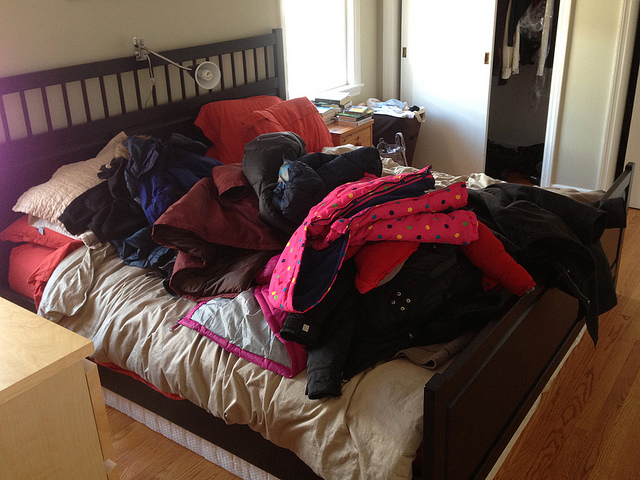

In [ ]:
# get coco example
idx = 15
caption = coco_train_captions[idx]
image = coco_img_name_vector[idx]
print(caption)
picture = Image.open(image)
picture

Ratchet Ratchet Chisel


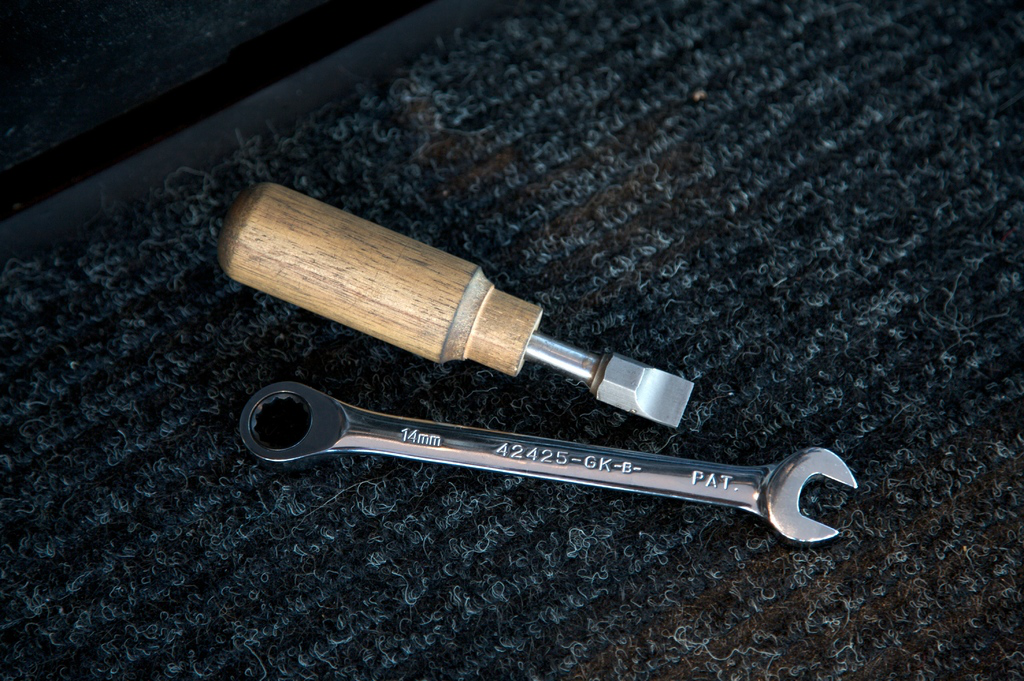

In [ ]:
# get open_images example
idx = 1991
open_image = open_image_img_name_vector[idx]
open_caption = open_image_caption[idx]
print(open_caption)
picture = Image.open(open_image)
picture

# get validation data

In [ ]:
# get open images validation images
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-27 01:18:21--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.225.144
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.225.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json’

nocaps_val_image_in 100%[===================>]   1.05M  2.82MB/s    in 0.4s    

2022-04-27 01:18:22 (2.82 MB/s) - ‘nocaps_val_image_info.json’ saved [1101959/1101959]



In [ ]:
# open json
import json
validation_open_images = "nocaps_val_image_info.json"
f1 = open(validation_open_images)
validation_open_images = json.load(f1)
f1.close()

In [ ]:
validation_open_images["images"][0]

{'coco_url': 'https://s3.amazonaws.com/nocaps/val/0013ea2087020901.jpg',
 'date_captured': '2018-11-06 11:04:33',
 'file_name': '0013ea2087020901.jpg',
 'height': 1024,
 'id': 0,
 'license': 0,
 'open_images_id': '0013ea2087020901',
 'width': 732}

In [ ]:
# from PIL import Image
# import requests

# for image in validation_open_images["images"][0:5]:
#   im = Image.open(requests.get(image['coco_url'], stream=True).raw)
#   #display(im)

## get coco validation data

In [ ]:
# Download image files
image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 173s 0us/step


In [ ]:
if os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_file = 'annotations/captions_val2014.json'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
train_coco_image_path_to_caption = collections.defaultdict(list)
for train in annotations['annotations']:
  caption = f"<start> {train['caption']} <end>"
  train_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (train['image_id'])
  train_coco_image_path_to_caption[train_image_path].append(caption)

## get open images validation data

In [ ]:
# get open images validation captions
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-27 01:22:06--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.196.104
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.196.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json.1’

nocaps_val_image_in 100%[===================>]   1.05M  2.78MB/s    in 0.4s    

2022-04-27 01:22:07 (2.78 MB/s) - ‘nocaps_val_image_info.json.1’ saved [1101959/1101959]



# get test data

## get coco test data

## get open images test data

In [ ]:
# get open images test captions
!wget https://s3.amazonaws.com/nocaps/nocaps_test_image_info.json

--2022-04-27 01:22:07--  https://s3.amazonaws.com/nocaps/nocaps_test_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.96.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.96.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2613626 (2.5M) [application/json]
Saving to: ‘nocaps_test_image_info.json’

nocaps_test_image_i 100%[===================>]   2.49M  5.66MB/s    in 0.4s    

2022-04-27 01:22:08 (5.66 MB/s) - ‘nocaps_test_image_info.json’ saved [2613626/2613626]



In [ ]:
# get data examples


# data preprocess

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(data_train_images))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(data_train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(data_train_images, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(23547, 23547, 5776, 5776)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 256
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# model

In [ ]:
class MultiplcativeAttention(tf.keras.Model):
  def __init__(self, units):
    super(MultiplcativeAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features,state):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(state, 1) 
    #print("hidden shape: ", hidden.shape) # (64, 256)

    # attention_hidden_layer shape == (batch_size, 64, units)
    #print("vector shapes: ", features.shape, hidden_with_time_axis.shape) #(64, 64, 256) (64, 1, 256)
    #features_sum = tf.math.reduce_sum(features, axis = 1, keepdims = False)
    #print("0:", features_sum.shape, state.shape)
    attention_hidden_layer = tf.matmul(features, hidden_with_time_axis, transpose_b=True) # tf.reduce_sum( tf.multiply( features_sum, state ), 1, keepdims=True )
    #print("1:", attention_hidden_layer.shape)
    #attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    #K = self.W1(features)
    #Q = self.W2(hidden_with_time_axis)
    #print("K and Q shape: ", K.shape, Q.shape, features.shape, hidden_with_time_axis.shape)
    #attention_hidden_layer = tf.linalg.matmul(K, Q, transpose_b=True)

    #print("attention_hidden_layer dim:",attention_hidden_layer) # (64, 64, 256)

    #tf.tensordot(features,hidden_with_time_axis,axes = 0) 
    #print("attention_hidden_layer dim: ", attention_hidden_layer.shape)
    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = attention_hidden_layer #                          #self.V(attention_hidden_layer) # (64, 64, 1)
    #print("score dim:", score.shape)
    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    #print("2:", attention_weights.shape, features.shape) # (64, 1) (64, 64, 256)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context_vector dim:", context_vector.shape)
    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        #print("encode fc dim:", x)

        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    #self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = MultiplcativeAttention(self.units)

  def call(self, x, features):
    #print("input dim x, features, hidden:", x.shape, features.shape, hidden.shape)
    # defining attention as a separate model
    #print("x shape:",x.shape) # (64, 1)
    #x = self.embedding(x)
    #print("x shape:",x.shape) # (64, 1, 256)
    #_, state = self.gru(x)
    #print("shape test:",x.shape,hidden.shape, state.shape,features.shape) # (64, 1, 256) (64, 256) (64, 256) (64, 64, 256)
    #print("1:", x.shape)
    x = self.embedding(x)
    #print("2:", x.shape)
    output, state = self.gru(x)
    #print("3:", output.shape, state.shape)

    context_vector, attention_weights = self.attention(features, state) #(features:image,state:captions)
    #print("4:",context_vector.shape)

    #print("context vector dim: ", context_vector.shape)
    #print("attention weights dim: ", attention_weights.shape)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    #x = self.embedding(x)
    #print("embedding dim:", x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #print("5:",x.shape)
    #print("concat dim:", x)

    # passing the concatenated vector to the GRU
    #output, state = self.gru(x)
    #print("gru dim:", output)

    # shape == (batch_size, max_length, hidden_size)
    #x = self.fc1(output)
    #print("decode fc1 dim:", x)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    #print("6:",x.shape)


    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    #print("7:",x.shape)

    #print("decode fc2 dim:", x)


    return x, state, attention_weights # predictions, hidden, _

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
import keras.backend as K
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  #print("loss shapes:", real.shape,pred.shape,mask.shape)
  #print("values:", tf.print(pred))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

# training

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  #print("hidden shape: ", hidden.shape)
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
  #print("dec input: ",dec_input.shape)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      #print("features shape:",features.shape) # (64,64,256)


      for i in range(1, target.shape[1]):
          #print("target one:",target.shape[1])
          #print("test i:", i)
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features)
          #print("target shape: ",target[:,i].shape) (64,)
          #print("pred shape: ",predictions.shape) (64,5000)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        #print("image shape, caption shape:",img_tensor.shape, target.shape)
        #print("target:",target)
        #print("target:",target[0])
        batch_loss, t_loss = train_step(img_tensor, target)
        
        #print("--------------------------------")
        total_loss += t_loss

        if batch % 10 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    #print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    #print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.6779
Epoch 1 Batch 10 Loss 1.3578
Epoch 1 Batch 20 Loss 1.4415
Epoch 1 Batch 30 Loss 1.1818
Epoch 1 Batch 40 Loss 1.2130
Epoch 1 Batch 50 Loss 1.0882
Epoch 1 Batch 60 Loss 1.1368
Epoch 1 Batch 70 Loss 1.2779
Epoch 1 Batch 80 Loss 1.0521
Epoch 1 Batch 90 Loss 1.1025
Epoch 1 Batch 100 Loss 1.1628
Epoch 1 Batch 110 Loss 1.1528
Epoch 1 Batch 120 Loss 1.0294
Epoch 1 Batch 130 Loss 1.1415
Epoch 1 Batch 140 Loss 1.0450
Epoch 1 Batch 150 Loss 1.0311
Epoch 1 Batch 160 Loss 0.9872
Epoch 1 Batch 170 Loss 1.0769
Epoch 1 Batch 180 Loss 0.9767
Epoch 1 Batch 190 Loss 0.9701
Epoch 1 Batch 200 Loss 0.9316
Epoch 1 Batch 210 Loss 0.9493
Epoch 1 Batch 220 Loss 1.1613
Epoch 1 Batch 230 Loss 0.9195
Epoch 1 Batch 240 Loss 0.9386
Epoch 1 Batch 250 Loss 0.9541
Epoch 1 Batch 260 Loss 0.8319
Epoch 1 Batch 270 Loss 0.9298
Epoch 1 Batch 280 Loss 0.9353
Epoch 1 Batch 290 Loss 0.9410
Epoch 1 Batch 300 Loss 0.8340
Epoch 1 Batch 310 Loss 0.8942
Epoch 1 Batch 320 Loss 0.8184
Epoch 1 Batch 330 Los

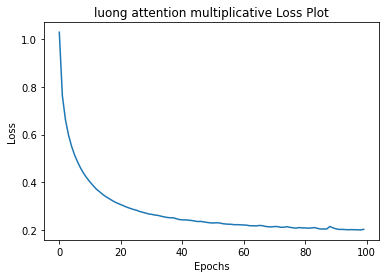

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('luong attention multiplicative Loss Plot')
plt.show()

# save model locally

In [ ]:
ckpt_manager.checkpoints[0]

'./checkpoints/train/ckpt-16'

In [ ]:
!zip -r checkpoints_luong_dot.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/train/ (stored 0%)
  adding: checkpoints/train/ckpt-20.data-00000-of-00001 (deflated 9%)
  adding: checkpoints/train/ckpt-20.index (deflated 64%)
  adding: checkpoints/train/ckpt-17.index (deflated 64%)
  adding: checkpoints/train/checkpoint (deflated 72%)
  adding: checkpoints/train/ckpt-18.index (deflated 64%)
  adding: checkpoints/train/ckpt-18.data-00000-of-00001 (deflated 9%)
  adding: checkpoints/train/ckpt-19.data-00000-of-00001 (deflated 9%)
  adding: checkpoints/train/ckpt-19.index (deflated 64%)
  adding: checkpoints/train/ckpt-17.data-00000-of-00001 (deflated 9%)
  adding: checkpoints/train/ckpt-16.index (deflated 64%)
  adding: checkpoints/train/ckpt-16.data-00000-of-00001 (deflated 9%)


In [ ]:
from google.colab import files
files.download("checkpoints_luong_dot.zip")

#files.download(checkpoint_path + "/checkpoint")
#files.download(checkpoint_path + "/ckpt-1.data-00000-of-00001")
#files.download(checkpoint_path + "/ckpt-1.index")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#!zip -r open_images_data.zip OID

In [ ]:
#files.download("open_images_data.zip")

In [ ]:
print(ckpt_manager.checkpoints)

['./checkpoints/train/ckpt-16', './checkpoints/train/ckpt-17', './checkpoints/train/ckpt-18', './checkpoints/train/ckpt-19', './checkpoints/train/ckpt-20']


# load model (testing)

In [ ]:
# encoder2 = CNN_Encoder(embedding_dim)
# decoder2 = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
# checkpoint_path = "./checkpoints/train/ckpt-1" #.index"
# ckpt = tf.train.Checkpoint(encoder=encoder2,
#                            decoder=decoder2,
#                            optimizer=optimizer)
# model = ckpt.restore(checkpoint_path)


In [ ]:
# def evaluate2(image):
#     attention_plot = np.zeros((max_length, attention_features_shape))

#     hidden = decoder.reset_state(batch_size=1)

#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
#                                                  -1,
#                                                  img_tensor_val.shape[3]))
#     #print(img_tensor_val.shape)
#     features = encoder2(img_tensor_val)

#     dec_input = tf.expand_dims([word_to_index('<start>')], 0)
#     result = []

#     for i in range(max_length):
#         predictions, hidden, attention_weights = decoder2(dec_input,
#                                                          features,
#                                                          hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#         #print(predictions.shape)
#         #predicted_id = tf.math.argmax(predictions,axis=1)[0].numpy()
#         #print("test:",predicted_id)
#         predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
#         result.append(predicted_word)

#         if predicted_word == '<end>':
#             return result, attention_plot

#         dec_input = tf.expand_dims([predicted_id], 0)

#     attention_plot = attention_plot[:len(result), :]
#     return result, attention_plot

In [ ]:
# # captions on the validation set
# rid = 0 #np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate2(image)

# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))

# evaluation

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    #print(img_tensor_val.shape)
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, _ , attention_weights = decoder(dec_input,
                                                         features)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print(predictions.shape)
        #predicted_id = tf.math.argmax(predictions,axis=1)[0].numpy()
        #print("test:",predicted_id)
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a colorful bird is surrounded by green and pink [UNK] <end>
Prediction Caption: red [UNK] <end>


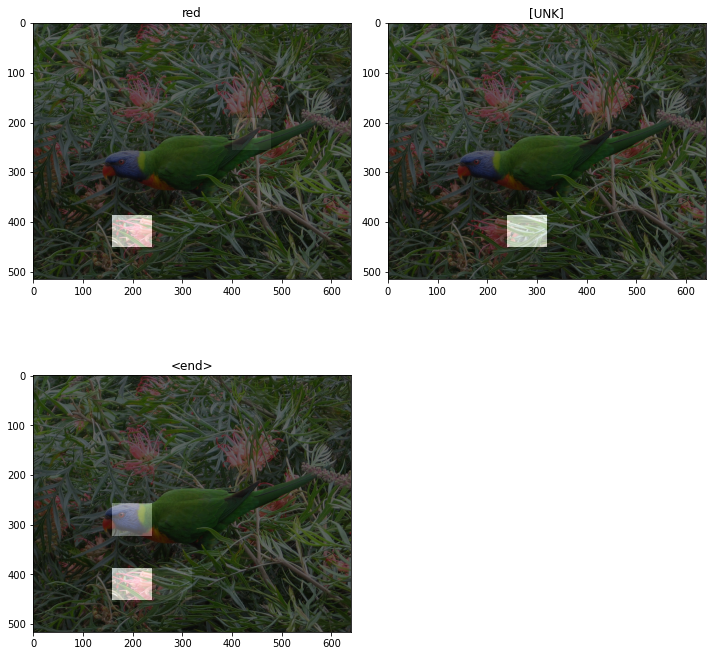

In [ ]:
# captions on the validation set
rid = 0 #np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# evaluation no caps (save file to send to server) (dont need to worry about the h5 files)

In [ ]:
!wget https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json

--2022-04-27 02:55:22--  https://s3.amazonaws.com/nocaps/nocaps_val_image_info.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.170.216
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.170.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1101959 (1.1M) [application/json]
Saving to: ‘nocaps_val_image_info.json.2’

nocaps_val_image_in 100%[===================>]   1.05M  2.12MB/s    in 0.5s    

2022-04-27 02:55:23 (2.12 MB/s) - ‘nocaps_val_image_info.json.2’ saved [1101959/1101959]



In [ ]:
!cp -r /content/drive/MyDrive/validation_images_data.zip validation_images_data.zip

In [ ]:
!unzip validation_images_data.zip

Archive:  validation_images_data.zip
   creating: image_folder/
  inflating: image_folder/134125cb6e64c943.jpg  
  inflating: image_folder/020c23f7e78ed8fa.jpg  
  inflating: image_folder/e47734b6ece6fb9c.jpg  
  inflating: image_folder/67e89bcc0dc88204.jpg  
  inflating: image_folder/62693d8625abb7f3.jpg  
  inflating: image_folder/acd8371d50566145.jpg  
  inflating: image_folder/898a4921ab9f4cce.jpg  
  inflating: image_folder/90ed7d97a19c3666.jpg  
  inflating: image_folder/6bd300d5eef039b5.jpg  
  inflating: image_folder/920cdf2d9f5a8b82.jpg  
  inflating: image_folder/e825ec29627d3091.jpg  
  inflating: image_folder/92c4c71c141773b1.jpg  
  inflating: image_folder/2772a4a9283e46fc.jpg  
  inflating: image_folder/ccd1baf21b64d13a.jpg  
  inflating: image_folder/d6686aeee94c1def.jpg  
  inflating: image_folder/3f1b06ad13105fda.jpg  
  inflating: image_folder/a71021cbcb420dc2.jpg  
  inflating: image_folder/89692f83a1c95938.jpg  
  inflating: image_folder/59aeea2e6faef44f.jpg  
  inf

In [ ]:
import json
file_name = 'nocaps_val_image_info.json'
with open(file_name, 'r') as f:
  data = json.load(f)

links = []
for element in data["images"]:
  links.append(element['coco_url'])

In [ ]:
data["images"][0]

{'coco_url': 'https://s3.amazonaws.com/nocaps/val/0013ea2087020901.jpg',
 'date_captured': '2018-11-06 11:04:33',
 'file_name': '0013ea2087020901.jpg',
 'height': 1024,
 'id': 0,
 'license': 0,
 'open_images_id': '0013ea2087020901',
 'width': 732}

In [ ]:
import urllib
# captions on the no-caps validation set
results = []
for image_data in data["images"]:
  image_id = image_data["id"]
  file_name = image_data["file_name"] 
  caption, attention_plot = evaluate("image_folder/" + file_name)
  #image_id = os.path.splitext(os.path.basename(image_link))[0]
  caption_str = " ".join(caption)
  result_object = {"image_id": image_id, "caption": caption_str}
  results.append(result_object)
  #print(result_object)

with open("result_captions_luong_dot.json", "w") as f:
  json.dump(results,f)
# my_df = pd.DataFrame(results)
# my_df.to_csv('results_test.csv', index=False, header=False)

#note optimize this as its too long

In [ ]:
from google.colab import files
files.download("result_captions_luong_dot.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>